Loading The Dataset From Kaggle


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d farzadnekouei/trash-type-image-dataset

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown
100% 40.9M/40.9M [00:02<00:00, 23.2MB/s]
100% 40.9M/40.9M [00:02<00:00, 14.7MB/s]


In [ ]:
!unzip trash-type-image-dataset.zip -d /content/drive/MyDrive/dataset

Archive:  trash-type-image-dataset.zip
replace /content/drive/MyDrive/dataset/TrashType_Image_Dataset/cardboard/cardboard_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/dataset/TrashType_Image_Dataset/cardboard/cardboard_002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/drive/MyDrive/dataset/TrashType_Image_Dataset/cardboard/cardboard_003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 200

Creating Pipeline to access the dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset/TrashType_Image_Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2527 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

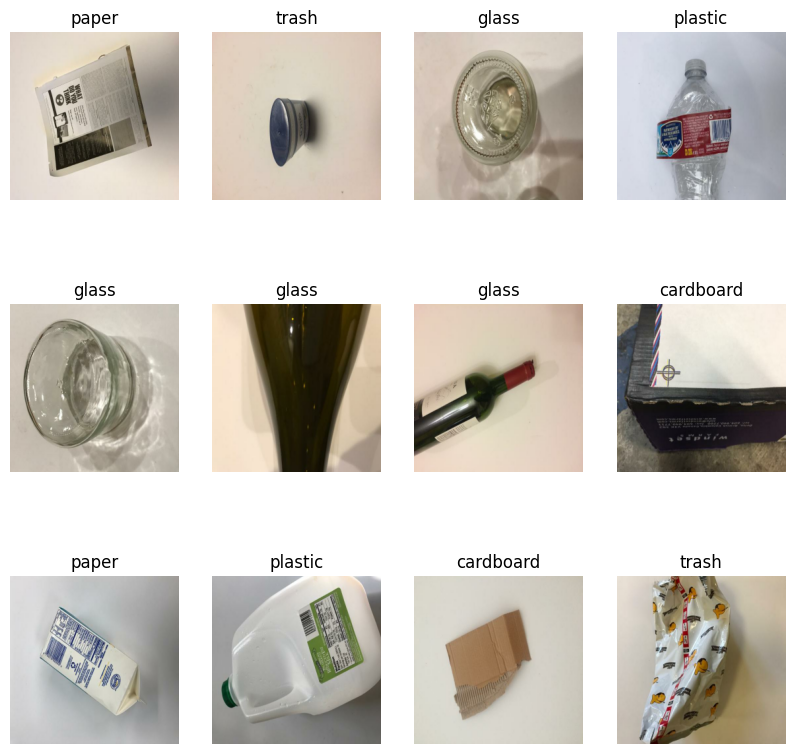

In [ ]:
plt.figure(figsize = (10,10))
for image_batch , label_batch in dataset.take(2):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

Spliting The Dataset

In [ ]:
def split_dataset(
    df,
    train_split = 0.8,
    val_split = 0.1,
    test_split = 0.1,
    shuffle = True,
    shuffle_size = 10000):
  if shuffle:
    df = df.shuffle(shuffle_size, seed = 10)

  DATASET_LENGTH = len(dataset)
  train_df = df.take(int(DATASET_LENGTH * train_split))
  val_df = df.skip(int(DATASET_LENGTH * train_split)).take(int(DATASET_LENGTH * val_split))
  test_df = df.skip(int(DATASET_LENGTH * (train_split + val_split))).take(int(DATASET_LENGTH * test_split))

  return train_df , val_df , test_df

In [ ]:
train_df , val_df , test_df = split_dataset(dataset)

In [ ]:
len(train_df) , len(val_df) , len(test_df)

(63, 7, 7)

In [ ]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Preprocessing the Image

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Build Model

In [ ]:
n_classes = len(class_names)
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size = (3,3) , activation = 'relu' , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_14 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [ ]:
model.compile(
    optimizer = Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_df,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_df
)

Epoch 1/200
63/63 [==============================] - 26s 215ms/step - loss: 1.6867 - accuracy: 0.3335 - val_loss: 3.8054 - val_accuracy: 0.2377
Epoch 2/200
63/63 [==============================] - 4s 68ms/step - loss: 1.4181 - accuracy: 0.4283 - val_loss: 8.3176 - val_accuracy: 0.2646
Epoch 3/200
63/63 [==============================] - 4s 68ms/step - loss: 1.3609 - accuracy: 0.4551 - val_loss: 3.4449 - val_accuracy: 0.2691
Epoch 4/200
63/63 [==============================] - 4s 67ms/step - loss: 1.3206 - accuracy: 0.4849 - val_loss: 6.2663 - val_accuracy: 0.2870
Epoch 5/200
63/63 [==============================] - 4s 70ms/step - loss: 1.2804 - accuracy: 0.5087 - val_loss: 3.4123 - val_accuracy: 0.2601
Epoch 6/200
63/63 [==============================] - 4s 67ms/step - loss: 1.3116 - accuracy: 0.4888 - val_loss: 3.4783 - val_accuracy: 0.2287
Epoch 7/200
63/63 [==============================] - 4s 68ms/step - loss: 1.2309 - accuracy: 0.5201 - val_loss: 2.2135 - val_accuracy: 0.3094
Epoc

Testing the Model

In [ ]:
scores = model.evaluate(test_df)

7/7 [==============================] - 9s 28ms/step - loss: 0.4070 - accuracy: 0.8661


In [ ]:
scores

[0.4070107042789459, 0.8660714030265808]

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 200, 'steps': 63}


Accuracy and Loss of Model

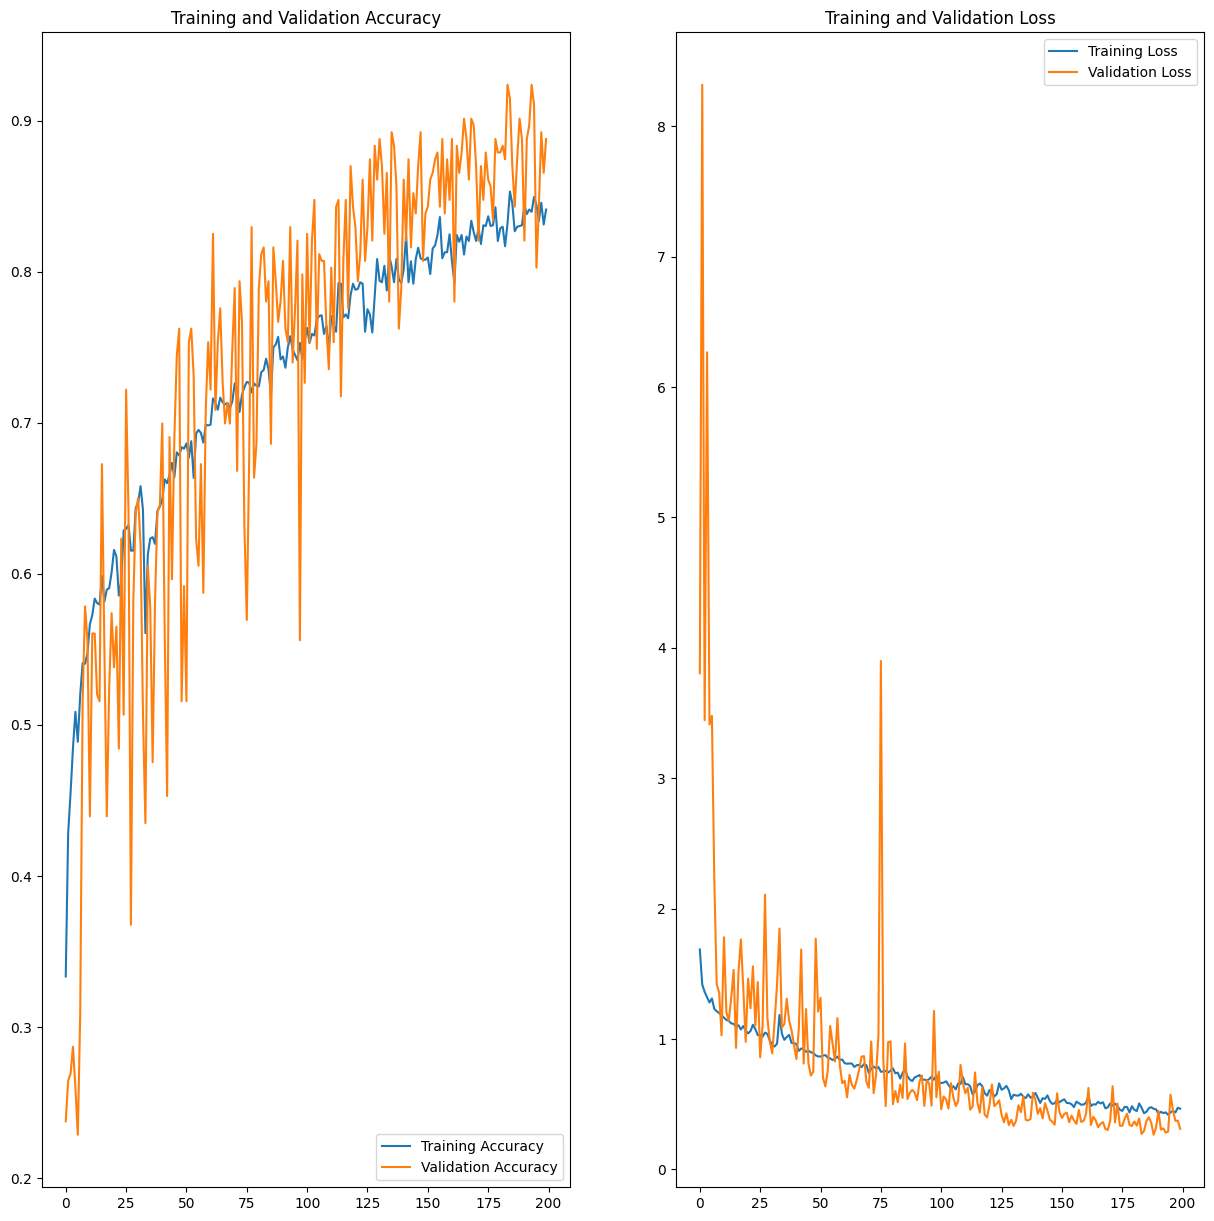

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label = "Training Accuracy")
plt.plot(epochs_range,val_acc,label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label = "Training Loss")
plt.plot(epochs_range,val_loss,label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

first image to predict
actual label: glass
1/1 [==============================] - 0s 120ms/step
predicted label: paper
first image to predict
actual label: cardboard
1/1 [==============================] - 0s 40ms/step
predicted label: cardboard
first image to predict
actual label: glass
1/1 [==============================] - 0s 45ms/step
predicted label: glass
first image to predict
actual label: trash
1/1 [==============================] - 0s 44ms/step
predicted label: trash
first image to predict
actual label: metal
1/1 [==============================] - 0s 42ms/step
predicted label: metal


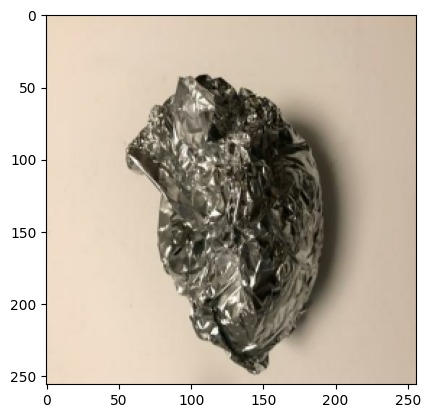

In [ ]:
import numpy as np
for images_batch, labels_batch in test_df.take(5):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Prediction

1/1 [==============================] - 0s 18ms/step


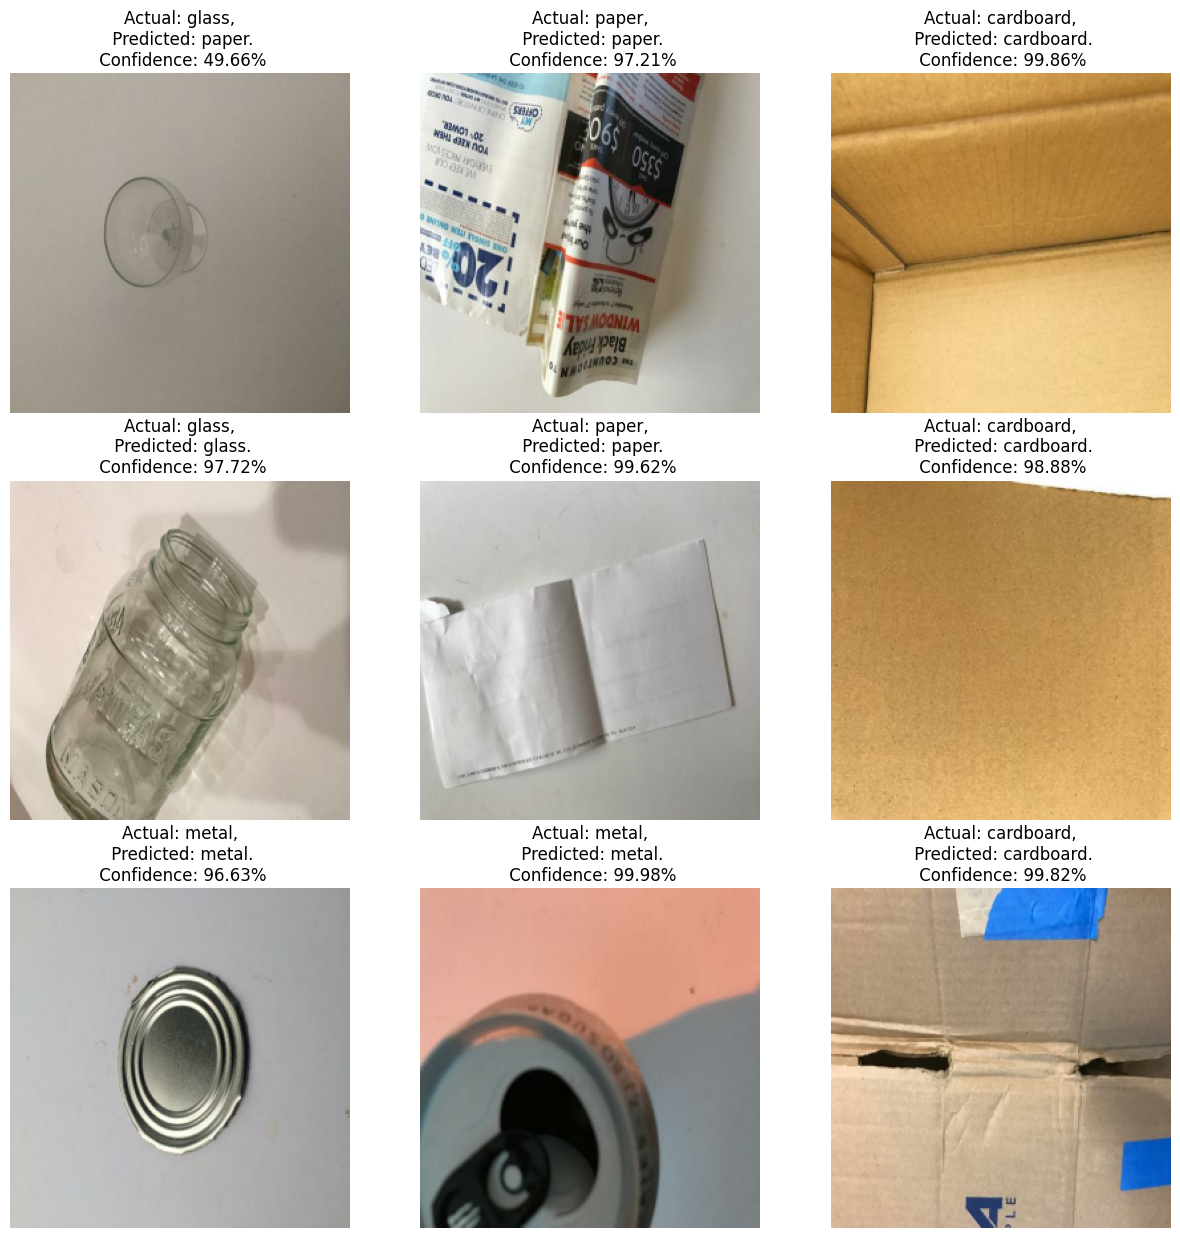

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model.save('/content/drive/MyDrive/models/TrashTypeModel')